# BERT

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers, layers, models

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
def predictions_func(model_input):
    predictions = model_input.predict(test["Sentence"].values)
    predictions2 = le.inverse_transform(np.argmax(predictions, axis = 1))
    print(classification_report(test["Sentiment"].values, predictions2))
    
    cm = confusion_matrix(test["Sentiment"].values, predictions2)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = le.classes_)
    disp.plot()

In [5]:
def plot_results(history):
    
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    
    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training','Validation'])

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training','Validation'])

    plt.show()

## Loading data and preprocessing labels

In [6]:
# Read the data files:

train = pd.read_csv("/home/linus/Documents/Skola/financial_sentiment_analysis_project/Data/train.csv")
valid = pd.read_csv("/home/linus/Documents/Skola/financial_sentiment_analysis_project/Data/valid.csv")
test = pd.read_csv("/home/linus/Documents/Skola/financial_sentiment_analysis_project/Data/test.csv")

# The balanced training set
train_balanced = pd.read_csv("/home/linus/Documents/Skola/financial_sentiment_analysis_project/Data/train_balanced.csv")

In [7]:
le = LabelEncoder()


numeric_labels = le.fit_transform(train["Sentiment"])
Y_train = to_categorical(le.fit_transform(train["Sentiment"]))
Y_valid = to_categorical(le.fit_transform(valid["Sentiment"]))
Y_test = to_categorical(le.fit_transform(test["Sentiment"]))

le_balanced = LabelEncoder()
Y_train_balanced = to_categorical(le_balanced.fit_transform(train_balanced["Sentiment"]))

## Loading the BERT model

In [ ]:
# Setting up BERT

preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4",
    trainable=False) # Setting this to False -> keeping the layer frozen

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
encoder_inputs = preprocessor(text_input)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]      # [batch_size, 768].
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 768].
bert = tf.keras.Model(text_input, sequence_output)

In [9]:
model = keras.Sequential()
model.add(bert)
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.LSTM(10))
model.add(tf.keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(3, activation = "softmax"))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 128, 768)          109482241 
                                                                 
 dropout (Dropout)           (None, 128, 768)          0         
                                                                 
 lstm (LSTM)                 (None, 10)                31160     
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense (Dense)               (None, 3)                 33        
                                                                 
Total params: 109,513,434
Trainable params: 31,193
Non-trainable params: 109,482,241
_________________________________________________________________


In [11]:
model.compile(optimizer = Adam(learning_rate = 0.01,), metrics = ['accuracy'], loss = CategoricalCrossentropy())

In [15]:
BERT_fit1 = model.fit(x = train["Sentence"].values, y = Y_train, 
                    batch_size = 64, epochs = 20, validation_data = (valid["Sentence"].values, Y_valid))

Epoch 1/20
46/46 [==============================] - 11s 230ms/step - loss: 0.3024 - accuracy: 0.8885 - val_loss: 0.5153 - val_accuracy: 0.8163
Epoch 2/20
46/46 [==============================] - 10s 218ms/step - loss: 0.2955 - accuracy: 0.8934 - val_loss: 0.5054 - val_accuracy: 0.8091
Epoch 3/20
46/46 [==============================] - 10s 227ms/step - loss: 0.2778 - accuracy: 0.8965 - val_loss: 0.5479 - val_accuracy: 0.8122
Epoch 4/20
46/46 [==============================] - 11s 247ms/step - loss: 0.2458 - accuracy: 0.9102 - val_loss: 0.5752 - val_accuracy: 0.7895
Epoch 5/20
46/46 [==============================] - 11s 245ms/step - loss: 0.2310 - accuracy: 0.9240 - val_loss: 0.5833 - val_accuracy: 0.8050
Epoch 6/20
46/46 [==============================] - 12s 252ms/step - loss: 0.2548 - accuracy: 0.9075 - val_loss: 0.5466 - val_accuracy: 0.8070
Epoch 7/20
46/46 [==============================] - 11s 243ms/step - loss: 0.2148 - accuracy: 0.9278 - val_loss: 0.5903 - val_accuracy: 0.8070

31/31 [==============================] - 2s 79ms/step
              precision    recall  f1-score   support

    negative       0.76      0.73      0.74       119
     neutral       0.84      0.86      0.85       575
    positive       0.71      0.68      0.70       276

    accuracy                           0.79       970
   macro avg       0.77      0.76      0.76       970
weighted avg       0.79      0.79      0.79       970



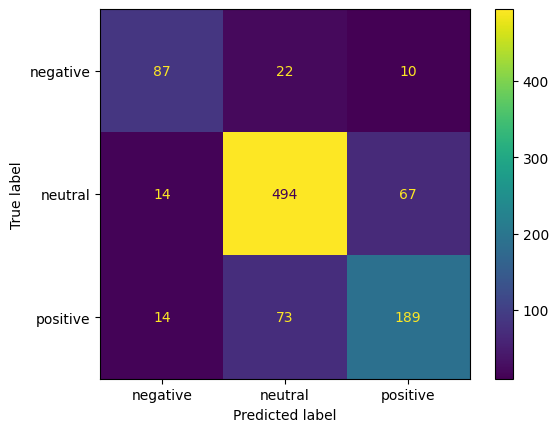

In [18]:
predictions_func(model)

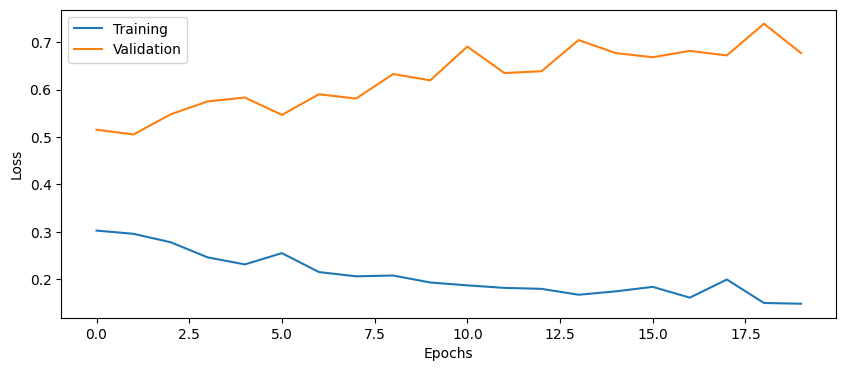

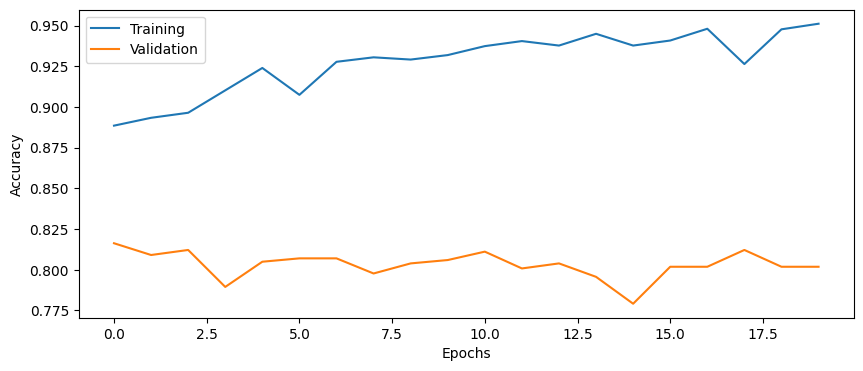

In [17]:
plot_results(BERT_fit1)

# Using the best model I found with LSTMs & Experiment with dropout rate

In [75]:
model2 = keras.Sequential()
model2.add(bert)
model2.add(tf.keras.layers.Dropout(0.25))
model2.add(tf.keras.layers.LSTM(32))
model2.add(tf.keras.layers.Dropout(0.25))
model2.add(keras.layers.Dense(64, activation = "relu"))
model2.add(keras.layers.Dense(3, activation = "softmax"))

In [76]:
model2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 128, 768)          109482241 
                                                                 
 dropout_16 (Dropout)        (None, 128, 768)          0         
                                                                 
 lstm_8 (LSTM)               (None, 32)                102528    
                                                                 
 dropout_17 (Dropout)        (None, 32)                0         
                                                                 
 dense_15 (Dense)            (None, 64)                2112      
                                                                 
 dense_16 (Dense)            (None, 3)                 195       
                                                                 
Total params: 109,587,076
Trainable params: 104,835
No

In [77]:
model2.compile(optimizer = Adam(learning_rate = 0.01,), metrics = ['accuracy'], loss = CategoricalCrossentropy())

In [78]:
BERT_fit2 = model2.fit(x = train["Sentence"].values, y = Y_train, 
                    batch_size = 64, epochs = 50, validation_data = (valid["Sentence"].values, Y_valid))

Epoch 1/50
46/46 [==============================] - 14s 255ms/step - loss: 0.8124 - accuracy: 0.6288 - val_loss: 0.7161 - val_accuracy: 0.6842
Epoch 2/50
46/46 [==============================] - 11s 232ms/step - loss: 0.7018 - accuracy: 0.6901 - val_loss: 0.6015 - val_accuracy: 0.7513
Epoch 3/50
46/46 [==============================] - 10s 222ms/step - loss: 0.6193 - accuracy: 0.7341 - val_loss: 0.5685 - val_accuracy: 0.7441
Epoch 4/50
46/46 [==============================] - 10s 226ms/step - loss: 0.5382 - accuracy: 0.7730 - val_loss: 0.5386 - val_accuracy: 0.7699
Epoch 5/50
46/46 [==============================] - 11s 230ms/step - loss: 0.4798 - accuracy: 0.7926 - val_loss: 0.5128 - val_accuracy: 0.7812
Epoch 6/50
46/46 [==============================] - 11s 232ms/step - loss: 0.4358 - accuracy: 0.8160 - val_loss: 0.5073 - val_accuracy: 0.7802
Epoch 7/50
46/46 [==============================] - 10s 217ms/step - loss: 0.4206 - accuracy: 0.8263 - val_loss: 0.4943 - val_accuracy: 0.7915

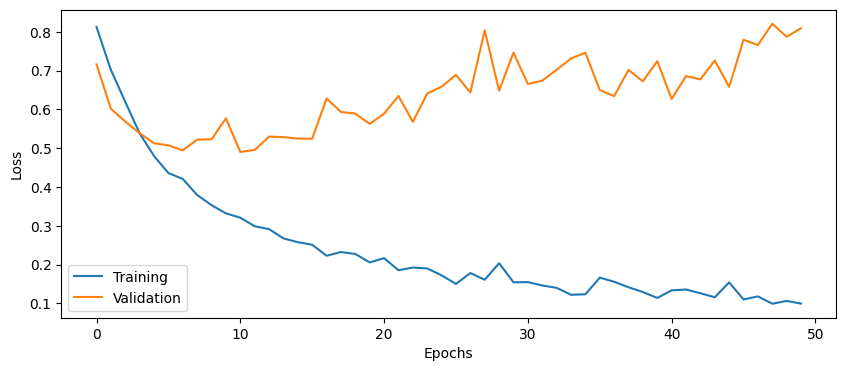

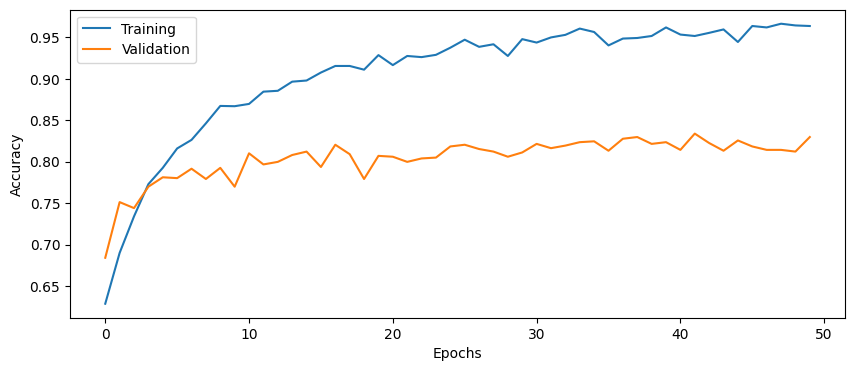

In [79]:
plot_results(BERT_fit2)

31/31 [==============================] - 3s 83ms/step
              precision    recall  f1-score   support

    negative       0.77      0.75      0.76       119
     neutral       0.80      0.90      0.85       575
    positive       0.76      0.57      0.65       276

    accuracy                           0.79       970
   macro avg       0.78      0.74      0.75       970
weighted avg       0.79      0.79      0.78       970



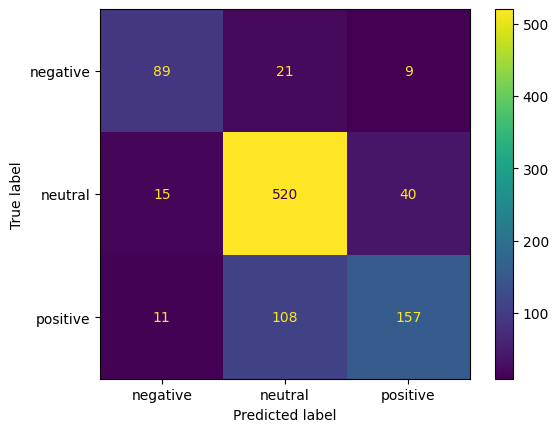

In [80]:
predictions_func(model2)

Using a large dropout rate, the overfitting issue seems to have increased, the training accuracy is much lower. Need more epochs of training.

Rate = 0.7 seems to result in underfitting instead.

# Attempt with balanced data

In [70]:
model3 = keras.Sequential()
model3.add(bert)
model3.add(tf.keras.layers.Dropout(0.25))
model3.add(tf.keras.layers.LSTM(32))
model3.add(tf.keras.layers.Dropout(0.25))
model3.add(keras.layers.Dense(64, activation = "relu"))
model3.add(keras.layers.Dense(3, activation = "softmax"))

In [71]:
model3.compile(optimizer = Adam(learning_rate = 0.01,), metrics = ['accuracy'], loss = CategoricalCrossentropy())

In [72]:
BERT_fit3_balanced = model3.fit(x = train_balanced["Sentences"].values, y = Y_train_balanced, 
                    batch_size = 64, epochs = 10, validation_data = (valid["Sentence"].values, Y_valid))

Epoch 1/10
81/81 [==============================] - 20s 206ms/step - loss: 0.8048 - accuracy: 0.6198 - val_loss: 0.7943 - val_accuracy: 0.5655
Epoch 2/10
81/81 [==============================] - 16s 200ms/step - loss: 0.5624 - accuracy: 0.7625 - val_loss: 0.5704 - val_accuracy: 0.7647
Epoch 3/10
81/81 [==============================] - 16s 197ms/step - loss: 0.4586 - accuracy: 0.8117 - val_loss: 0.5643 - val_accuracy: 0.7564
Epoch 4/10
81/81 [==============================] - 16s 199ms/step - loss: 0.4061 - accuracy: 0.8443 - val_loss: 0.6280 - val_accuracy: 0.7317
Epoch 5/10
81/81 [==============================] - 16s 197ms/step - loss: 0.3613 - accuracy: 0.8657 - val_loss: 0.5478 - val_accuracy: 0.7905
Epoch 6/10
81/81 [==============================] - 16s 197ms/step - loss: 0.3284 - accuracy: 0.8776 - val_loss: 0.5567 - val_accuracy: 0.7957
Epoch 7/10
81/81 [==============================] - 16s 200ms/step - loss: 0.3220 - accuracy: 0.8776 - val_loss: 0.5506 - val_accuracy: 0.8060

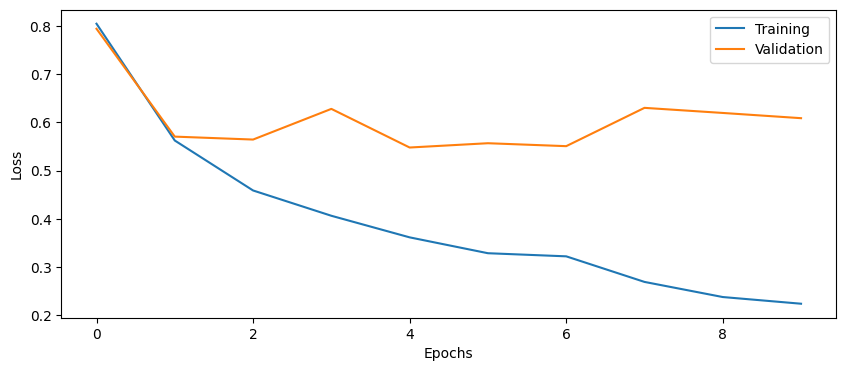

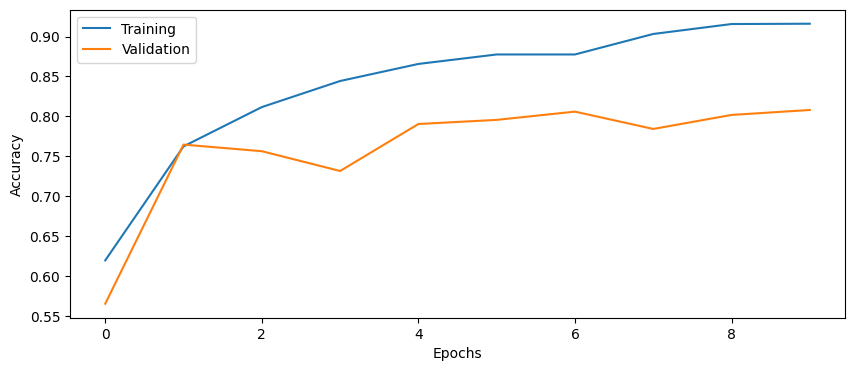

In [73]:
plot_results(BERT_fit3_balanced)

31/31 [==============================] - 2s 79ms/step
              precision    recall  f1-score   support

    negative       0.72      0.71      0.72       119
     neutral       0.80      0.90      0.85       575
    positive       0.75      0.57      0.65       276

    accuracy                           0.78       970
   macro avg       0.76      0.73      0.74       970
weighted avg       0.78      0.78      0.78       970



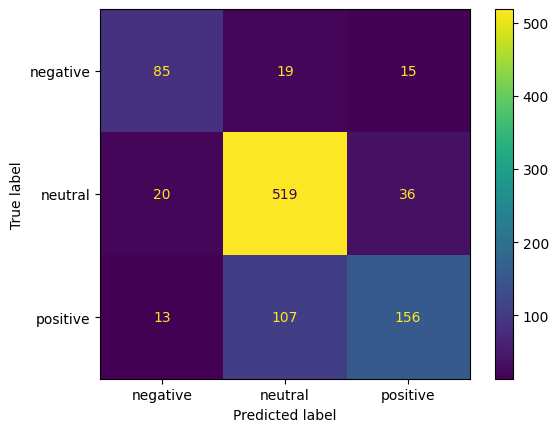

In [74]:
predictions_func(model2)

# Summary

In general, the predictive performance has imrpoved using BERT compared to the self-trained word embedding. The issue with overfitting which needs to be adressed.
        -> Future studies and limitation: Dealing with overfitting.
        
Using the oversampling technique did not improve overall accuracy, neither did it imimrpove precision, recall or f1-score for each class.
        -> Future studies and limitation: Explore alternative resampling techniques
 
Error analysis: The model seem to confuse neutral with positive class quite alot. The recall for the positive class is much lower compared to the other two. Perhaps issues with the data? -> Noisy labels.

Training time is not that big.
        TODO: Measure the time it takes to traing both models.

# Links used

https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4

https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3

https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb#scrollTo=_OoF9mebuSZc

https://stackoverflow.com/questions/45755022/cannot-add-layers-to-saved-keras-model-model-object-has-no-attribute-add